# Spheromones

This is a collection of funny things you can do with/on spheres. It's still work in progress and will likely be expanded slightly over time. If you feel like contributing to it you're very welcome to do so!

In [1]:
import base64
import time

import geopy
import geojson
import pandas as pd
import numpy as np
import ipyvolume as ipv
import PIL.Image
from ipyleaflet import Map, GeoJSON, Polyline
from ipyvolume.datasets import UrlCached
from ipywidgets import interact

from utils import extract_coords, extract_lines
from utils import latlon2xyz, lonlat2xyz

## Warm-Up

In [2]:
ipv.quickscatter(*np.random.random((3, 10_000)), marker="sphere")

In [3]:
x, y, z = np.random.random((3, 10_000))
color = np.array([x, y, z]).T
ipv.quickscatter(x, y, z, size=z*5, color=color, marker="sphere")

In [4]:
ipv.figure()
x, y, z = np.random.random((3, 10_000))
scatter = ipv.scatter(x, y, z, marker='sphere')
ipv.show()

In [5]:
x, y, z = np.random.random((3, 10_000))
scatter.color = np.array([x, y, z]).T
scatter.x = x
scatter.y = y
scatter.z = z

## Random Points

In [6]:
# %load -n latlon2xyz

In [7]:
lat = 90 * 2 * (np.random.random(10_000) - 0.5)
lon = 180 * 2 * (np.random.random(10_000) - 0.5)
points = [latlon2xyz(*latlon) for latlon in zip(lat, lon)]
x, y, z = np.array(points).T
ipv.quickscatter(x, y, z, size=.5, marker='sphere')

In [8]:
ipv.figure()
x, y, z = (np.random.random((3, 10_000)) - 0.5) * 2
d = np.sqrt(x**2 + y**2 + z**2)
scatter = ipv.scatter(x/d, y/d , z/d, size=.5, marker='sphere') # box
ipv.xyzlim(-1, 1)
ipv.show()

In [9]:
d = np.sqrt(x**2 + y**2 + z**2)
scatter.x = x
scatter.y = y
scatter.z = z

In [10]:
ipv.figure()
for col in 'red blue green'.split():
    x, y, z = (np.random.random((3, 100)) - 0.5)
    d = np.sqrt(x**2 + y**2 + z**2)
    ipv.plot(x/d, y/d , z/d, color=col)
ipv.show()

## Grids

In [11]:
lon = np.arange(-180, 180, 15)
lat = np.arange(-90, 90 + 15, 15)
points = [latlon2xyz(yi, xi) for xi in lon for yi in lat]
x, y, z = np.array(points).T

ipv.figure()
ipv.scatter(x, y, z, size=2, color='red', marker='sphere')
ipv.xyzlim(-1, 1)
ipv.show()

In [12]:
delta = 15
lon = np.arange(-180, 180 + delta, delta)
lat = np.arange(-90, 90 + delta, delta)

ipv.figure()
for yi in lat:
    points = [latlon2xyz(yi, xi) for xi in lon]
    x, y, z = np.array(points).T
    ipv.plot(x, y, z, color='red')
for xi in lon:
    points = [latlon2xyz(yi, xi) for yi in lat]
    x, y, z = np.array(points).T
    p = ipv.plot(x, y, z, color='blue')
ipv.show()

## Solid Spheres

Use a ThreeJS primitive which cannot be further configured.

In [13]:
ipv.figure()
x, y, z = np.array([[0.], [0.], [0.]])
ipv.scatter(x, y, z, size=100, marker="sphere")
ipv.xyzlim(-0.5, 0.5)
ipv.show()

Reimplemented with variable grid:

In [14]:
def spherical_grid(num_lon, num_lat, r=1):
    "Return array of points on a regular longitude/latitude spherical grid."
    lon = np.linspace(0, 2*np.pi, num_lon)
    lat = np.linspace(-np.pi/2, np.pi/2, num_lat)
    lon, lat = np.meshgrid(lon, lat)
    x = np.ravel(r * np.cos(lat) * np.cos(lon))
    y = np.ravel(r * np.cos(lat) * np.sin(lon))
    z = np.ravel(np.sin(lat))
    return np.array([x, y, z]).T

In [15]:
def tri(num_lon, num_lat, x):
    "Triangulate spherical grid."
    # FIXME: debug off-by-one issues with num_lon, num_lat
    # FIXME: remove need for x
    l = len(x)
    for j in range(num_lat+1):
        for i in range(num_lon+1):
            a, b, c = [i*num_lat+j, i*num_lat+j+1, i*num_lat+j+num_lon]
            if a < l and b < l and c < l:
                yield [a, b, c]
            a, b, c = [i*num_lat+j+1, i*num_lat+j+num_lon, i*num_lat+j+num_lon+1]
            if a < l and b < l and c < l:
                yield [a, b, c]

In [16]:
num_lon = 12
num_lat = 13  # FIXME...
ipv.figure()
points = spherical_grid(num_lon=num_lon, num_lat=num_lat)
x, y, z = points.T
triangles = list(tri(num_lon, num_lat, x))
ipv.plot_trisurf(x, y, z, triangles=triangles)
ipv.xyzlim(-1, 1)
ipv.show()

There is a simpler and more efficient way to create spheres using meshes which is shown in a later subsection.

## Thou shall triangulate!

In [17]:
def triangulate(triangle, level=0):
    "Return a spherical triangle triangulated into four triangles."
    if level == 0:
        yield triangle
    else:
        a, b, c = triangle
        ab2, bc2, ac2 = (a+b)/2, (b+c)/2, (a+c)/2
        ab2, bc2, ac2 = [v / np.linalg.norm(v) for v in [ab2, bc2, ac2]]
        for tri in triangulate([a, ab2, ac2], level-1):
            yield tri
        for tri in triangulate([b, ab2, bc2], level-1):
            yield tri
        for tri in triangulate([c, ac2, bc2], level-1):
            yield tri
        for tri in triangulate([ab2, bc2, ac2], level-1):
            yield tri

In [18]:
lonlats = [(0, 0), (90, 0), (0, 90)]
points = np.array([lonlat2xyz(lon, lat) for (lon, lat) in lonlats])
ipv.figure()
pts = np.concatenate(list(triangulate(points, level=1)))
ipv.scatter(*pts.T, marker='sphere', size=3)
ipv.scatter(*points, marker='sphere', size=5)
# ipv.plot_trisurf(*pts[-3:], triangles=[[0, 1, 2]])
ipv.xyzlim(-1, 1)
ipv.show()

In [19]:
lonlats = [(0, 0), (90, 0), (-90, 0), (0, 90), (0, -90), (180, 0)]
points = np.array([lonlat2xyz(lon, lat) for (lon, lat) in lonlats])
surfaces = [
    (0, 1, 3),
    (0, 2, 3),
    (0, 1, 4),
    (0, 2, 4),
    (5, 1, 3),
    (5, 2, 3),
    (5, 1, 4),
    (5, 2, 4),
]

In [20]:
level = 1
ipv.figure()
for i, j, k in surfaces:
    triangle = points[i], points[j], points[k]
    pts = np.concatenate(list(triangulate(triangle, level=level)))
    x, y, z = pts.T
    ipv.scatter(x, y, z, marker='sphere', size=3)
ipv.xyzlim(-1, 1)
ipv.show()

In [21]:
level = 1
ipv.figure()
for i, j, k in surfaces:
    triangle = points[i], points[j], points[k]
    pts = np.concatenate(list(triangulate(triangle, level=level)))
    x, y, z = pts.T
    # color = np.array([x, y, z]).T
    # ipv.scatter(x, y, z, marker='sphere', size=3, color=color)
    tris = [list(sub) for sub in np.split(np.arange(len(pts)), len(pts)/3)]
    ipv.plot_trisurf(x, y, z, triangles=tris) # , color=color)
ipv.xyzlim(-1, 1)
ipv.show()

## Globes

Points from CSV 

In [22]:
df = pd.read_csv('airports.csv', sep=';')

In [23]:
df.describe()

,id,latitude_deg,longitude_deg,elevation_ft
count,50565.000000,50565.000000,50565.000000,45623.000000
mean,61776.379492,325.278487,145.201261,1218.804178
std,100199.027796,4373.736381,11245.208486,1562.020658
min,2.000000,-64824.000000,-168095.000000,-1266.000000
25%,12760.000000,6.094167,-92.258499,205.000000
50%,25483.000000,36.686901,-73.349602,715.000000
75%,40573.000000,44.183201,12.457864,1477.000000
max,322150.000000,78214.000000,177368.000000,22000.000000


In [24]:
df.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR,NaN,NaN,NaN
4,322127,00AS,small_airport,Fulton Airport,34.942803,-97.818019,1100.0,NaN,US,US-OK,Alex,no,00AS,NaN,00AS,NaN,NaN,NaN


In [25]:
lat = df.latitude_deg.values
lon = df.longitude_deg.values
z = [latlon2xyz(*latlon) for latlon in zip(lat, lon)]
x, y, z = np.array(z).T
ipv.quickscatter(x, y, z, size=.2, color='red', marker='sphere')

GeoJSON on flat maps

In [26]:
data = geojson.load(open('globe.geojson'))

In [27]:
m = Map(center=(0, 0), zoom=1)
m

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Lines extracted from GeoJSON on a flat map

In [28]:
g = GeoJSON(data=data, style={'color': 'green'})
m += g

In [29]:
# %load -n extract_lines

In [30]:
lines = list(extract_lines(data))
for line in lines:
    if len(np.array(line).shape) < 2:
        line = line[0]
    L = len(line)
    if L == 1:
        line = line[0]
    rline = [(lat, lon) for (lon, lat) in line]
    m += Polyline(locations=rline, color='red', fill_color='red',
                  opacity=1, weight=1, dash_array='2', fill_opacity=0.1)

In [31]:
m -= g

Single points on a globe

In [32]:
# %load -n extract_coords

In [33]:
ipv.figure()
lon, lat = np.array(list(extract_coords(data))).T
z = [latlon2xyz(yi, xi) for (yi, xi) in zip(lat, lon)]
x, y, z = np.array(z).T
ipv.scatter(x, y, z, size=0.5, color='red', marker='sphere')
ipv.xyzlim(-1, 1)
ipv.show()

In [34]:
len(x)

9916

Lines extracted from GeoJSON on a globe

In [35]:
ipv.figure()
x, y, z = np.array([[0.], [0.], [0.]])
ipv.scatter(x, y, z, size=100, color='blue', marker="sphere")
lines = list(extract_lines(data))
for line in lines:
    if len(np.array(line).shape) < 2:
        line = line[0]
    L = len(line)
    if L == 1:
        line = line[0]
    z = [lonlat2xyz(lon, lat) for (lon, lat) in line]
    x, y, z = np.array(z).T
    ipv.plot(x, y, z, color='#aaffaa')
ipv.xyzlim(-1, 1)
ipv.show()

Moving around

In [36]:
def set_lat_lon(lat, lon):
    # x, y, z = np.array(latlon2xyz(lat, lon)).reshape(3, 1)
    # ipv.scatter(x,y, z, size=5, color='red', marker='sphere')
    ipv.view(azimuth=lon, elevation=lat)

In [37]:
set_lat_lon(52.3, 14.5)

In [38]:
def set_location(location: str):
    gc = geopy.geocoders.Nominatim
    loc = gc(user_agent="spheromones").geocode(query=location)
    ipv.view(loc.longitude, loc.latitude)

In [39]:
set_location('chicago')

In [40]:
for lat in np.linspace(0, 90, 1000):
    set_lat_lon(52.3, lat)

Record movie (this needs ImageMagick to be installed!)

In [41]:
def set_view(figure, framenr, fraction):
    ipv.view(fraction*180, (fraction - 0.5) * 180)

ipv.movie('globe.gif', set_view, fps=20, frames=40, gif_loop=None)

Output()

Play recorded movie


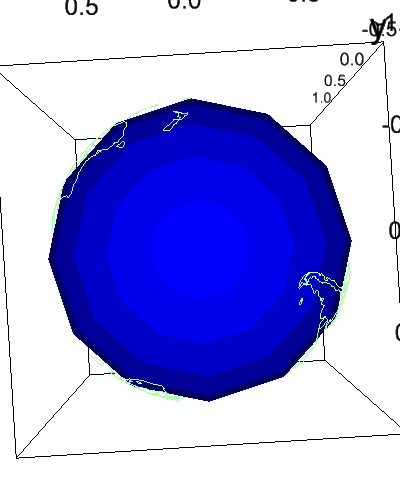

In [42]:
from IPython.display import Image
with open('globe.gif', 'rb') as gif:
    url = b"data:image/gif;base64," + base64.b64encode(gif.read())
Image(url=url.decode('ascii'))

## Textures

Get terrain image to be used as texture image from:

- http://vterrain.org/Imagery/WholeEarth/
- https://eoimages.gsfc.nasa.gov/images/imagerecords/57000/57752/land_shallow_topo_2048.jpg

In [43]:
image = PIL.Image.open('land_shallow_topo_2048.jpg')

In [44]:
X = np.arange(-5, 6, 1)
Y = np.arange(-5, 6, 1)
X, Y = np.meshgrid(X, Y)
Z = X * 0 + 1

fig = ipv.figure()
u = (X-5) / 10
v = (Y-5) / 10
ipv.plot_mesh(X, Y, Z, u=u, v=v, texture=image, wireframe=True)
ipv.show()

This shows clearly how not to do it...

In [45]:
a = np.arange(-1, 1.1, 0.1)
X, Y = np.meshgrid(a, a)
Z = np.sqrt(1**2 - X**2 - Y**2)

ipv.figure()
ipv.plot_surface(X, Z, Y, color="orange")
ipv.plot_wireframe(X, Z, Y, color="red")
ipv.xyzlim(-1, 1)
ipv.show()

/Users/gherman/dinuconda/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
a = np.arange(-1, 1.05, 0.05)
U, V = np.meshgrid(a, a)
X = U
Y = V
Z = np.sqrt(1**2 - X**2 - Y**2)

fig = ipv.figure()
u = (X-1) / 2
v = (Y-1) / 2
mesh = ipv.plot_mesh(X, Y, Z, u=u, v=v, texture=image, wireframe=False)
ipv.xyzlim(-1, 1)
ipv.show()

/Users/gherman/dinuconda/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


## Proper mapping of a texture to a sphere

A common application is to map a cylindrical map of the Earth onto a sphere. To accomplish this, one must use [UV mappings](https://en.wikipedia.org/wiki/UV_mapping). For a nice reference on these mapping, consult [this article](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/01/spheremap.pdf) on the detailed math behind the projections. (This section was contributed by [@grburgess](https://github.com/grburgess) and [@maartenbreddels](https://github.com/maartenbreddels).)

In [47]:
x, y, z = 0, 0, 0
radius = 1
num = 12

u = np.linspace(0, 1, num + 1)
v = np.linspace(0, 1, num + 1)
u, v = np.meshgrid(u, v)
phi = u * 2 * np.pi
theta = v * np.pi
x = x + radius * np.cos(phi) * np.sin(theta)
y = y + radius * np.cos(theta)
z = z + radius * np.sin(phi) * np.sin(theta)

ipv.figure()
ipv.plot_surface(x, y, z, color="orange")
ipv.plot_wireframe(x, y, z, color="red")
ipv.xyzlim(-1, 1)
ipv.show()

In [48]:
def sphere(x, y, z, radius, num=30, color=None, texture=None, wireframe=False):
    """Create a sphere mesh with origin at x, y, z and radius.
    """
    assert num > 0
    u = np.linspace(0, 1, num + 1)
    v = np.linspace(0, 1, num + 1)
    u, v = np.meshgrid(u, v)
    phi = u * 2 * np.pi
    theta = v * np.pi
    x = x + radius * np.cos(phi) * np.sin(theta)
    y = y + radius * np.cos(theta)
    z = z + radius * np.sin(phi) * np.sin(theta)

    kwargs = dict(color=color or "blue", texture=texture, wireframe=wireframe)
    return ipv.plot_mesh(x, y, z, u=0.75-u, v=1-v, **kwargs)

In [49]:
@interact()
def show_sphere(num=(4, 36)):
    fig = ipv.figure()
    sphere(0, 0, 0, radius=1, num=num)
    ipv.show()

interactive(children=(IntSlider(value=20, description='num', max=36, min=4), Output()), _dom_classes=('widget-…

In [50]:
fig = ipv.figure()
image = PIL.Image.open('land_shallow_topo_2048.jpg')
sphere(0, 0, 0, radius=1, num=24, texture=image) # 6381

data = geojson.load(open('globe.geojson'))
lon, lat = np.array(list(extract_coords(data))).T
z = [latlon2xyz(yi, xi) for (yi, xi) in zip(lat, lon)]
x, y, z = np.array(z).T
ipv.scatter(x, y, z, size=0.5, color='limegreen', marker='sphere')
ipv.show()

In [51]:
image = PIL.Image.open('land_shallow_topo_2048.jpg')

@interact
def retexture(num=(3, 30)):
    fig = ipv.figure()
    s = sphere(0, 0, 0, radius=1, num=num+1, texture=image)
    ipv.show()
    return s

interactive(children=(IntSlider(value=16, description='num', max=30, min=3), Output()), _dom_classes=('widget-…

In [52]:
# url = "http://images.planet-mofo.com/A-Delusion/mofo%20art%20from%20ATD/DV-deathstar-texture.png"

# https://www.jpl.nasa.gov/spaceimages/details.php?id=PIA07782
url = "https://www.jpl.nasa.gov/spaceimages/images/largesize/PIA07782_hires.jpg"
image_file = UrlCached(url)
image = PIL.Image.open(image_file.fetch())

In [53]:
fig = ipv.figure()
sphere(0, 0, 0, radius=1, texture=image, num=100)
ipv.show()
for lon in np.linspace(0, 360, 360):
    time.sleep(0.036)
    ipv.view(lon, None)

## More to come... please stay tuned! ;)

- Charts?
- Animation?